# Projet Télédétection : Landes de Bretagne

## Partie 1 : Visualisation des échantillons

### Nombre d'échantillons

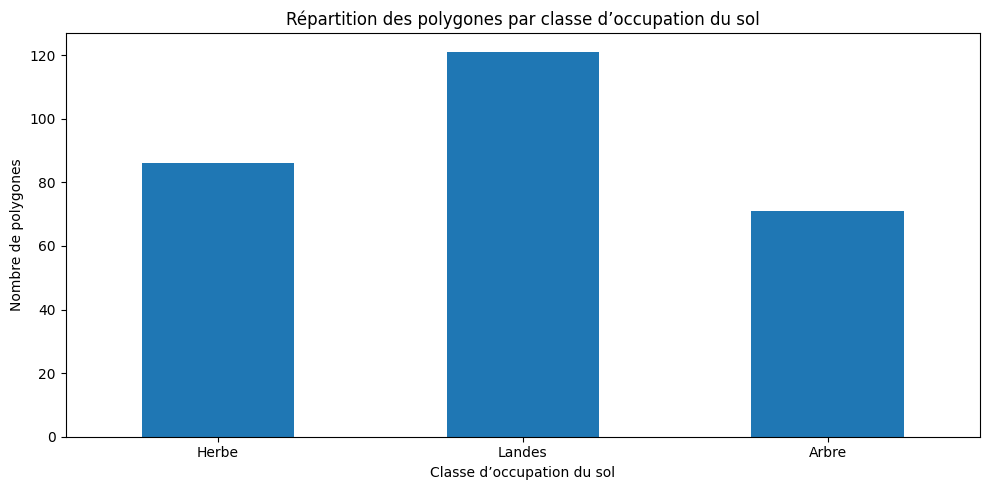

In [2]:
# --- Nombre de polygones par classe ---

import geopandas as gpd
import matplotlib.pyplot as plt
import os

os.makedirs("/home/onyxia/work/results/figure", exist_ok=True)  #Création du dossier results

gdf = gpd.read_file("../data/projet_eval/PI_strates_bretagne_32630.shp")   #Chargement en gdf pour le plot

classe = "strate"
counts = gdf[classe].value_counts().sort_index()    #comptage

#dictionnaire de correspondance code / classe pour les étiquettes
labels_strates = {  
    1: "Sol nu",
    2: "Herbe",
    3: "Landes",
    4: "Arbre"
}

#Remplacer les codes par les noms
counts.index = counts.index.map(labels_strates)

plt.figure(figsize=(10, 5))
counts.plot(kind="bar")

plt.xlabel("Classe d’occupation du sol")
plt.ylabel("Nombre de polygones")
plt.title("Répartition des polygones par classe d’occupation du sol")
plt.xticks(rotation=0)  #étiquettes horizontales

plt.tight_layout()

plt.savefig("../results/figure/diag_baton_nb_poly_by_class.png", dpi=300)

plt.show()

On remarque que l'échantillon ne contient pas un seul polygone de la classe "Sol nu". La classe "Landes" est la plus représentée tandis que les strates "Herbe" et "Arbre" sont à peu près équivalentes en nombre de polygones.

/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


0...10...20...30...40...50...60...70...80...90...100 - done.


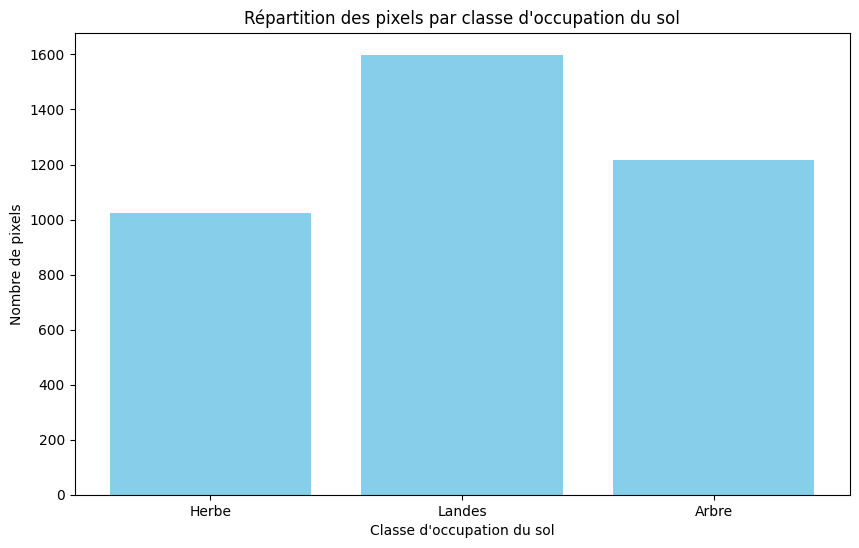

In [3]:
import os
from osgeo import gdal
import sys
from my_function import rasterization_from_model   #Appel fonction
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('/home/onyxia/work')

# --- Nombre de pixels par classe ---

# Rasterisation
# Définition des paramètres
field_name = "strate"
sptial_resolution = 10
in_vector = "../data/projet_eval/PI_strates_bretagne_32630.shp"
out_image = "../results/PI_strates_bretagne_32630.tif"
model = "../data/projet_eval/bretagne_24-25_B03.tif"

rasterization_from_model(in_vector, out_image, field_name, model)

# Comptage
# Ouvrir le raster
dataset = gdal.Open(out_image)

band = dataset.GetRasterBand(1)
data = band.ReadAsArray()

values, counts = np.unique(data, return_counts=True)

# Filtrer la classe 0 qui correspond à nodata
mask = values != 0
values = values[mask]
counts = counts[mask]

# Remplacer les codes par les noms
labels = [labels_strates.get(val, f"Classe {val}") for val in values]

# Réalisation du barplot
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel("Classe d'occupation du sol")
plt.ylabel("Nombre de pixels")
plt.title("Répartition des pixels par classe d'occupation du sol")

plt.savefig("../results/figure/diag_baton_nb_pix_by_class.png", dpi=300)

plt.show()


La distribution des pixels suit celle des polygones : La strate "Landes" est la plus représentée, et il n'y a aucun pixel de sol nu.

### Phénologie des strates, mise en évidence des landes

In [4]:
from libsigma import read_and_write

ds = gdal.Open("../data/projet_eval/bretagne_24-25_B03.tif")
read_and_write.get_pixel_size(ds, verbose=True)

print("Projection : ", ds.GetProjection())

raster_band = ds.GetRasterBand(1)
print("Nodata : ", raster_band.GetNoDataValue())


Pixel Size = (10.0, -10.0)
Projection :  PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]
Nodata :  None


Nous pouvons voir que le raster de la bande 3 pour Bretagne 2024-2025 est déjà dans la bonne projection et a déjà la bonne taille de pixel par rapport à ce qui est demandé. Cependant il n'y a pas de valeur de NoData définie, donc il faudra la préciser.

In [ ]:
import my_function


B03_path = "../data/projet_eval/bretagne_24-25_B03.tif"
B05_path = "../data/projet_eval/bretagne_24-25_B05.tif"

B03 = read_and_write.load_img_as_array(B03_path)
B05 = read_and_write.load_img_as_array(B05_path)

reference = gdal.Open(B03_path)

# Calcul NARI
nari = (1/B03 - 1/B05)/(1/B03 + 1/B05)

nodata = -9999
nari = np.where(np.isfinite(nari), nari, nodata)    #Remplacement de -inf, nan... par nodata

# Ecriture du raster
my_function.write_image_nd(
    "../results/ARI_serie_temp.tif", 
    array=nari, 
    data_set=reference, 
    gdal_dtype=gdal.GDT_Float32,
    nodata=-9999
    )


Maintenant affichons la série temporelle moyenne d'ARI par strate. Nous allons faire cela à partir de deux rasters : 
- le raster PI_strates_bretagne_32630.tif que nous avons créé pour la visualisation du nombre de pixels par classe
- le raster de série temporelle ARI que nous venons de créer.

Pour pouvoir faire correspondre classe et valeur d'ARI, nous devons nous assurer que ces deux rasters ont la même résolution spatiale et projection. Pour ce qui est de la résolution nous savons déjà qu'elle est de 10 m pour les deux puisque nous l'avons précisé lors de la création de chacun? Vérifions que les projections soient les mêmes :

In [9]:
ds1 = gdal.Open("../results/PI_strates_bretagne_32630.tif")
ds2 = gdal.Open("../results/ARI_serie_temp.tif")

print("Projection PI : ", ds1.GetProjection())
print("Projection ARI : ", ds2.GetProjection())

Projection PI :  PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]
Projection ARI :  PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["

Les deux rasters ont bien la même projection, nous pouvons procéder.

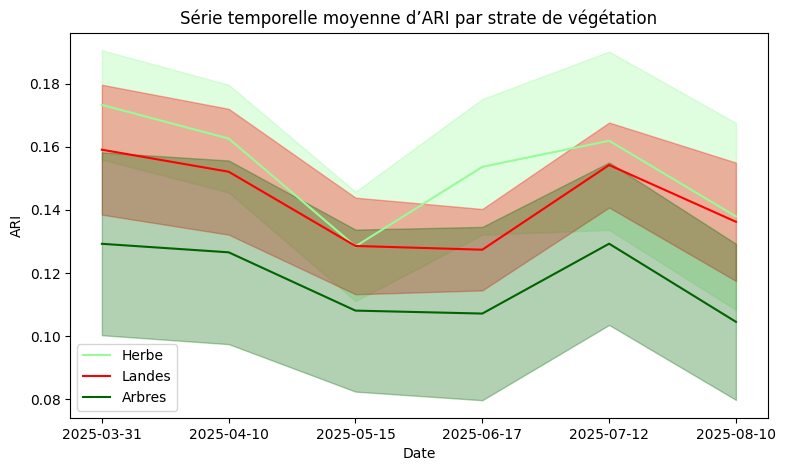

In [4]:
from libsigma import classification as cla

dict_X, Y, dict_t = cla.get_samples_from_roi(
    raster_name="../results/ARI_serie_temp.tif",
    roi_name="../results/PI_strates_bretagne_32630.tif",
    output_fmt='by_label'
)

#Calcul moyennes et écarts types
stats = {}

for label, X in dict_X.items():
    stats[label] = {
        "mean": X.mean(axis=0),
        "std": X.std(axis=0)
    }

#On trace le plot
fig, ax = plt.subplots(figsize=(9, 5))

colors = ['palegreen', 'red', 'darkgreen']
labels = ['Herbe', 'Landes', 'Arbres']

date = np.arange(next(iter(stats.values()))["mean"].shape[0])

for lab, color, name in zip(stats.keys(), colors, labels):
    mean = stats[lab]["mean"]
    std = stats[lab]["std"]

    ax.plot(date, mean, color=color, label=name)
    ax.fill_between(
        date,
        mean - std,
        mean + std,
        color=color,
        alpha=0.3
    )

ax.set_xlabel("Date")
ax.set_ylabel("ARI")
ax.set_title("Série temporelle moyenne d’ARI par strate de végétation")
ax.legend()

ax.set_xticks(range(6))
ticks_labels = []
bands_name = ['2025-03-31', '2025-04-10', '2025-05-15', '2025-06-17', '2025-07-12', '2025-08-10']
_ = ax.set_xticklabels(bands_name)

plt.savefig("../results/figure/ARI_series.png", dpi=300)

plt.show()

On constate sur le graphique produit que les landes ne se distinguent pas significativement des strates herbe et arbres par le score NARI. Les courbes des trois strates sont proches et les écarts types sont confondus.

## Partie 2 : Production d'une carte à l'échelle du pixel